In [1]:
import pandas as pd
import math
import numpy as np
import os
import math
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath('../')
sys.path.append(module_path)
from mobile_capacity.rmalos import RMaLOS as rmalos

In [2]:
def dbm_to_watts(dbm):
    """
    Convert power from dBm to watts.
    
    Parameters:
    dbm (float): Power in dBm.
    
    Returns:
    float: Power in watts.
    """
    watts = 10 ** (dbm / 10) / 1000
    return watts

def watts_to_dbm(watts):
    """
    Convert power from watts to dBm.
    
    Parameters:
    watts (float): Power in watts.
    
    Returns:
    float: Power in dBm.
    """
    dbm = 10 * np.log10(watts * 1000)
    return dbm

In [3]:
def calculate_noise_per_rb(temp_k=290, bandwidth_hz=180e3, noise_figure_db=5):
    """
    Calculate the noise power per Resource Block (RB) in LTE.
    
    Parameters:
    temp_k (float): Absolute temperature in Kelvin. Default is 290K.
    bandwidth_hz (float): Bandwidth of one RB in Hz. Default is 180kHz.
    noise_figure_db (float): Receiver noise figure in dB. Default is 5dB.
    
    Returns:
    float: Total noise power per RB in dBm.
    """
    # Constants
    boltzmann_constant = 1.38e-23  # Boltzmann constant in J/K
    
    # Calculate thermal noise power in Watts
    thermal_noise_power_w = boltzmann_constant * temp_k * bandwidth_hz
    
    # Convert thermal noise power to dBm
    # + 30 is used to convert the result from decibels (dB) to decibels-milliwatts (dBm)
    thermal_noise_power_dbm = 10 * math.log10(thermal_noise_power_w) + 30 
    
    # Add receiver noise figure to get total noise power
    total_noise_power_dbm = thermal_noise_power_dbm + noise_figure_db
    
    return total_noise_power_dbm

In [4]:
def select_bps_and_cr(sinr, mapping_table):
    """
    Selects bits per symbol and code rate based on the given SINR.

    Parameters:
    sinr (float): The SINR value in dB.
    mapping_table (pd.DataFrame): The SINR to CQI mapping table.

    Returns:
    bits_per_symbol (int): The bits per symbol value corresponding to the given SINR.
    code_rate (float): The code rate value corresponding to the given SINR.
    """

    # Find the closest SINR value without exceeding the given SINR
    valid_entries = mapping_table[mapping_table["SINR [dB]"] <= sinr]
    if valid_entries.empty:
        return None  # No valid CQI found for the given SINR
    closest_match = valid_entries.iloc[-1]
    bits_per_symbol = closest_match["Bits per Symbol"]
    code_rate = closest_match['Code Rate']
    return bits_per_symbol, code_rate

In [5]:
def select_bps_and_cr_vectorized(sinr, mapping_table):  
    """  
    Selects bits per symbol and code rate based on the given SINR.  
  
    Parameters:  
    sinr (array-like): The SINR values in dB.  
    mapping_table (pd.DataFrame): The SINR to CQI mapping table, sorted by 'SINR [dB]'.  
  
    Returns:  
    bits_per_symbol (np.array): The bits per symbol values corresponding to the given SINR.  
    code_rate (np.array): The code rate values corresponding to the given SINR.  
    """  
    # Ensure the SINR values are a NumPy array  
    sinr = np.asarray(sinr)  
  
    # Ensure the mapping_table is sorted by SINR values  
    mapping_table = mapping_table.sort_values('SINR [dB]')  
  
    # Get the SINR, bits per symbol, and code rate arrays from the mapping table  
    sinr_values = mapping_table['SINR [dB]'].values  
    bits_per_symbol_values = mapping_table['Bits per Symbol'].values  
    code_rate_values = mapping_table['Code Rate'].values  
  
    # Find the indices of the closest SINR values without exceeding the given SINR  
    indices = np.searchsorted(sinr_values, sinr, side='right') - 1  
  
    # Handle the case where the SINR is below the lowest value in the mapping table  
    indices = np.maximum(indices, 0)  
  
    # Select the bits per symbol and code rate based on the indices  
    bits_per_symbol = bits_per_symbol_values[indices]  
    code_rate = code_rate_values[indices]  
  
    return bits_per_symbol, code_rate  
  
# Example usage:  
sinr_values = np.array([-5.0, 0.0, 5.0, 10.0, 15.0, 20.0])  # Example SINR values in dB  
mapping_table = pd.DataFrame({  
    'SINR [dB]': [-6, -3, 0, 3, 6, 9, 12, 15, 18, 21],  
    'Bits per Symbol': [2, 2, 4, 4, 6, 6, 6, 8, 8, 8],  
    'Code Rate': [0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]  
})

In [6]:
# Parameters
# f = 1.8 # Frequency in GHz
hut = 4 # Height of the user terminal in m
hbs = 25 # Height of the base station antenna in m
h = 6 # Avg. Height of building in m
pnomref = 40 # Tx power of radio units in Watts
bw = 10 # Channel Bandwidth in MHz
bwrb = 0.180 # bandwidth per resource block in MHz
gtx = 17 # Gain of the Tx antenna in dBi
grx = 14 # Gain of the Rx antenna in dBi 
cco = 18 # Control channel overheads in %
nonbhu = 50 # Connection usage in non-busy hour in %
# los = False # True - LOS model, False - NLOS model # For future use, currently only RMA-LOS model is implemented
subcarriers_per_rb = 12
ofdm_symbols_per_slot = 7
slots_per_second = 2000

# SINR and CQI mapping table in LTE
# Source: https://comtech.vsb.cz/qualmob/sinr_lte.html
sinr_cqi_mapping_table = pd.DataFrame({
    "SINR [dB]": [-6.7, -4.7, -2.3, 0.2, 2.4, 4.3, 5.9, 8.1, 10.3, 11.7, 14.1, 16.3, 18.7, 21.0, 22.7],
    "CQI code": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "Modulation": ["QPSK"]*6 + ["16QAM"]*3 + ["64QAM"]*6,
    "Bits per Symbol": [2]*6 +[4]*3 + [6]*6,
    "Code Rate": [0.076, 0.12, 0.19, 0.3, 0.44, 0.59, 0.37, 0.48, 0.6, 0.45, 0.55, 0.65, 0.75, 0.85, 0.93]
})

sinr_cqi_mapping_table = pd.DataFrame(sinr_cqi_mapping_table)

# Initialize variables
count = 0
distances_df = pd.DataFrame()
lpmaxrb_df = pd.DataFrame()
throughput_df = pd.DataFrame()
combined_table = pd.DataFrame()
# bws = np.array([5, 10, 15, 20]) # bandwidth values in MHz for tables
fs = np.array([0.85, 1.8, 2.1, 2.6]) # frequency values in GHz for tables
start_dist = 1000 # meters
end_dist = 10000 # meters
step_dist = 100 # meters

# Calculate noise power per resource block
noise_per_rb = calculate_noise_per_rb(temp_k=290, bandwidth_hz=180e3, noise_figure_db=5)
pnomref_dbm = watts_to_dbm(pnomref)

for d in range(start_dist, end_dist, step_dist):
    combined_table.loc[count,'Distance'] = d / 1000 # Distance in km

    for f in fs:
        # Calculate pathloss
        path_loss = rmalos.pathloss(hbs, hut, f, d, h)
        combined_table.loc[count,'Path loss'] = path_loss
        # Calculate received signal power
        prx = pnomref_dbm + gtx + grx - path_loss
        combined_table.loc[count,'Prx'] = prx
        # Calculate transmitted power per resource block
        ptxrb = rmalos.ptxrb(bw, pnomref)
        combined_table.loc[count,'Ptx per RB'] = ptxrb
        # Calculate received power per resource block at the Rx antenna 
        lpmaxrb = rmalos.lpmax(ptxrb, gtx, grx, path_loss) 
        combined_table.loc[count,'Ptx per RB'] = lpmaxrb
        # Calculate signal to interference and noise ratio (SINR) per resource block
        sinr_rb = lpmaxrb - noise_per_rb
        combined_table.loc[count,'SINR'] = sinr_rb
        # Determine channel quality indicator (CQI)
        bits_per_symbol, code_rate = select_bps_and_cr(sinr_rb, sinr_cqi_mapping_table)
        combined_table.loc[count,'Bits per symbol'] = bits_per_symbol
        combined_table.loc[count,'Code rate'] = code_rate
        rb_num = bw * 5  # Number of Resource Blocks
        # Determine total available throughput in kbps
        overhead_factor = 1 - cco / 100 # Persentage of throughput used to transmit payload
        throughput = bits_per_symbol * code_rate * subcarriers_per_rb \
            * ofdm_symbols_per_slot * slots_per_second * rb_num * overhead_factor # Throughput in bits per second
        combined_table.loc[count,'Throughput'] = throughput
        
        # Fill in tables with data
        distances_df.loc[count, f'L{int(f * 1000)}'] = d / 1000 # Distances in km
        lpmaxrb_df.loc[count, f'L{int(f * 1000)}'] = lpmaxrb
        throughput_df.loc[count, f'L{int(f * 1000)}'] = throughput

        # Increase row count
    count += 1

In [7]:
distances_df.to_csv(os.path.join(module_path,'data','input_data','carrier_bandwidth','bwdistance_km.csv'), index=False)
throughput_df.to_csv(os.path.join(module_path,'data','input_data','carrier_bandwidth','bwdlachievbr_kbps.csv'), index=False)

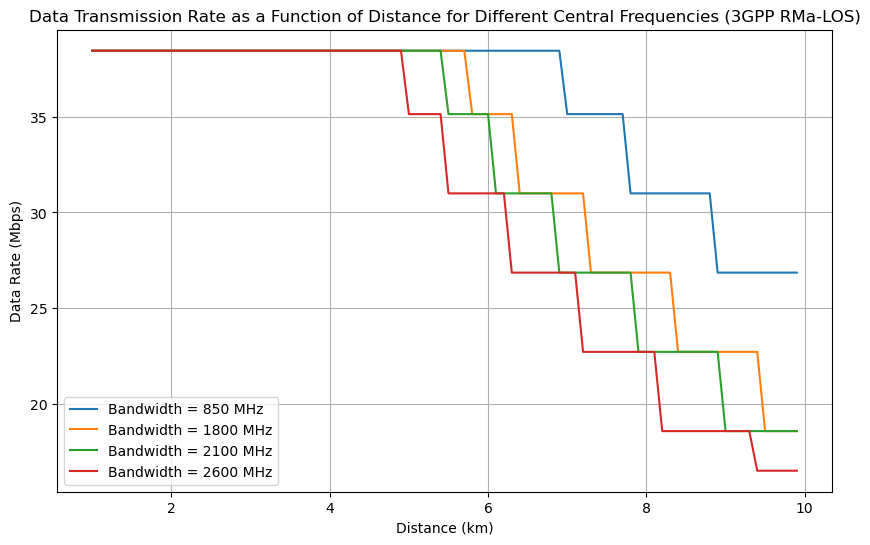

In [8]:
# Plotting
plt.figure(figsize=(10, 6))

for f in fs:
    distances_plot = distances_df.loc[:,f'L{int(f * 1000)}']
    throughput_plot = throughput_df.loc[:,f'L{int(f * 1000)}']
    plt.plot(distances_plot, throughput_plot/1000000, label=f'Bandwidth = {int(f * 1000)} MHz') # throughput_plot/1000000 - conversion to Mbps

plt.xlabel('Distance (km)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Transmission Rate as a Function of Distance for Different Central Frequencies (3GPP RMa-LOS)')
plt.legend()
plt.grid(True)
plt.show()

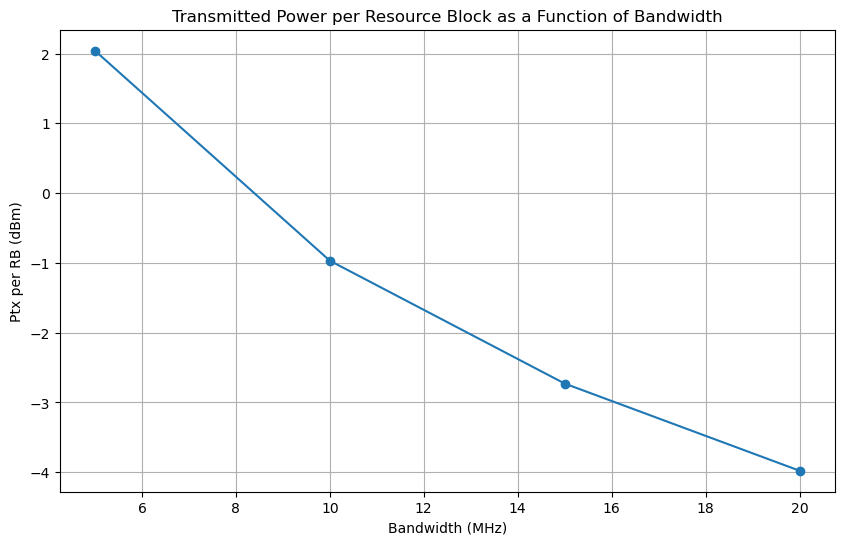

In [9]:
# Plotting Ptx per RB as a function of bandwidth
# Note that the power per resource block is decreasing with increasing bandwidth. 
# This is because the total transmitted power is fixed, and as the bandwidth increases, 
# the power per resource block decreases.
# This lead to a decrease in the signal-to-noise ratio (SNR) per resource block, 
# and thus a decrease in the achievable throughput.
# That is why the data rates at the same distance are different for different bandwidths.
# To keep the data rates the same, the transmitted power should be increased with increasing bandwidth.

bw_values = [5, 10, 15, 20]  # Bandwidth values in MHz
ptxrb_values = [rmalos.ptxrb(bw, pnomref) for bw in bw_values]

plt.figure(figsize=(10, 6))
plt.plot(bw_values, ptxrb_values, marker='o')
plt.xlabel('Bandwidth (MHz)')
plt.ylabel('Ptx per RB (dBm)')
plt.title('Transmitted Power per Resource Block as a Function of Bandwidth')
plt.grid(True)
plt.show()